In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
nba = pd.read_csv("final_table.csv", index_col=0)
nba.fillna(0, inplace=True)
import seaborn as sns
from statsmodels.discrete.discrete_model import Poisson as psn
import statsmodels.formula.api as smf

In [2]:
nba

,Player,tm,pos,yr2019_20,avg_cost_per_pt,Age,PER,pts,g,mp,ast,stl,blk
612,Luguentz Dort,OKC,SG,155647.0,637.90,20.0,7.6,244.0,36.0,820.0,27.0,31.0,4.0
587,Ky Bowman,GSW,PG,350189.0,1045.34,22.0,9.1,335.0,45.0,1015.0,131.0,44.0,10.0
545,Eric Paschall,GSW,PF,898310.0,1073.25,23.0,14.5,837.0,60.0,1654.0,127.0,32.0,13.0
606,PJ Dozier,DEN,PG,183115.0,1089.97,23.0,11.6,168.0,29.0,412.0,63.0,14.0,6.0
530,Devonte' Graham,CHO,PG,1416852.0,1237.43,24.0,15.8,1145.0,63.0,2211.0,471.0,62.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Sir'Dominic Pointer,0,0,50752.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
640,Isaiah Taylor,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,Tyler Lydon,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,Hollis Thompson,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# create database for g-league players and player who sat
# out and did not play all year 
games= nba[ nba['pts'] <= 100.0 ]
games

,Player,tm,pos,yr2019_20,avg_cost_per_pt,Age,PER,pts,g,mp,ast,stl,blk
637,Paul Watson,TOR,SF,50752.0,1637.16,25.0,-7.1,31.0,8.0,70.0,5.0,3.0,1.0
603,Cameron Payne,PHO,PG,196288.0,2256.18,25.0,15.7,87.0,8.0,183.0,24.0,8.0,2.0
614,Johnathan Williams,WAS,C,106181.0,2359.58,24.0,14.0,45.0,15.0,180.0,8.0,1.0,8.0
604,Mychal Mulder,GSW,SG,187782.0,2438.73,25.0,7.8,77.0,7.0,204.0,8.0,2.0,1.0
620,Donta Hall,BRK,PF,101504.0,3075.88,22.0,17.2,33.0,5.0,85.0,2.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Sir'Dominic Pointer,0,0,50752.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
640,Isaiah Taylor,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,Tyler Lydon,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,Hollis Thompson,0,0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(nba[nba['Player']=="Darius Bazley"])

            Player   tm pos  yr2019_20  avg_cost_per_pt   Age  PER    pts  \
384  Darius Bazley  OKC  PF  2284800.0           6680.7  19.0  9.6  342.0   

        g      mp   ast   stl   blk  
384  61.0  1130.0  41.0  23.0  41.0  


In [5]:
# remove players that did not play any games due to injury and G-league/developmental league players 
# based on nba salary scale and not to account those during predictions
index_names = nba[ nba['pts'] <= 100.0 ].index
# drop these row indexes 
# from dataFrame 
nba.drop(index_names, inplace = True) 
nba

,Player,tm,pos,yr2019_20,avg_cost_per_pt,Age,PER,pts,g,mp,ast,stl,blk
612,Luguentz Dort,OKC,SG,155647.0,637.90,20.0,7.6,244.0,36.0,820.0,27.0,31.0,4.0
587,Ky Bowman,GSW,PG,350189.0,1045.34,22.0,9.1,335.0,45.0,1015.0,131.0,44.0,10.0
545,Eric Paschall,GSW,PF,898310.0,1073.25,23.0,14.5,837.0,60.0,1654.0,127.0,32.0,13.0
606,PJ Dozier,DEN,PG,183115.0,1089.97,23.0,11.6,168.0,29.0,412.0,63.0,14.0,6.0
530,Devonte' Graham,CHO,PG,1416852.0,1237.43,24.0,15.8,1145.0,63.0,2211.0,471.0,62.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Gorgui Dieng,MEM,C,16229213.0,131944.82,30.0,17.8,123.0,17.0,318.0,15.0,14.0,17.0
95,Brandon Knight,DET,PG,15643750.0,150420.67,28.0,5.4,104.0,9.0,221.0,38.0,5.0,1.0
34,Otto Porter,CHI,SF,27250576.0,163177.10,26.0,15.8,167.0,14.0,331.0,25.0,15.0,6.0
40,Andre Drummond,CLE,C,27093019.0,193521.56,26.0,22.1,140.0,8.0,225.0,14.0,12.0,11.0


In [6]:
nba.columns

Index(['Player', 'tm', 'pos', 'yr2019_20', 'avg_cost_per_pt', 'Age', 'PER',
       'pts', 'g', 'mp', 'ast', 'stl', 'blk'],
      dtype='object')

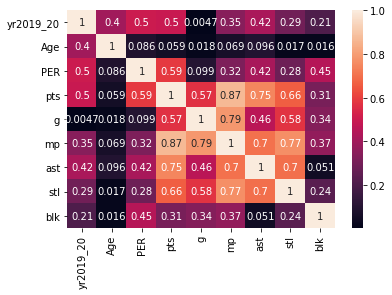

In [7]:
nba_corr = pd.DataFrame(nba[['yr2019_20', 'Age','PER','pts', 'g', 'mp', 'ast', 'stl', 'blk']])
corrMatrix = nba_corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [8]:
#mask = np.random.rand(len(nba))<0.8
# nba_train =nba[mask]
# nba_test=nba[~mask]
nba_train= nba
nba_test=nba
print ('training data set length='+str(len(nba_train)))
print("testing data set length="+str(len(nba_test)))

training data set length=345
testing data set length=345


In [9]:
# setup the regression in patsy notation. telling patsy that
#"yr2019_20"/salary is our dependent variable and it
# depends on the regression variables: age, per, pts, g, mp, ast, stl
# and blocks
expr = """yr2019_20~Age+PER+pts+g+mp+ast+stl+blk"""

In [10]:
# set up X and y
y_train,X_train= dmatrices(expr,nba_train,return_type='dataframe')
y_test, X_test = dmatrices(expr,nba_test, return_type='dataframe')

In [11]:
# using the statsmodel GLM class train the poisson regression model on the training set
poisson_training_results =sm.GLM(y_train,X_train, family=sm.families.Poisson()).fit()

In [12]:
poisson =poisson_training_results.summary()
print(poisson_training_results.summary())
#poisson2=np.array(poisson)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr2019_20   No. Observations:                  345
Model:                            GLM   Df Residuals:                      336
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.5367e+08
Date:                Mon, 14 Dec 2020   Deviance:                   1.1073e+09
Time:                        09:29:01   Pearson chi2:                 1.11e+09
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9748      0.000   7.61e+04      0.0

In [13]:
model = smf.ols("yr2019_20~Age+PER+pts+g+mp+ast+stl+blk", data = nba).fit()
#visualize the output of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              yr2019_20   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     48.98
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           5.21e-52
Time:                        09:29:02   Log-Likelihood:                -5894.4
No. Observations:                 345   AIC:                         1.181e+04
Df Residuals:                     336   BIC:                         1.184e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.309e+07   2.93e+06     -4.466      0.000   -1.89e+07   -7.33e+06
Age         7.979e+05   8.63e+04      9.248      0.000    6.28e+05    9.68e+05
PER         3.031e+05   1.23e+05      2.458      0.014    6.05e+04    5.46e+05
pts         6986.3259   2568.199      2.720      0.007    1934.552     1.2e+04
g           -2.83e+05   3.75e+04     -7.541      0.000   -3.57e+05   -2.09e+05
mp          3980.4709   2091.730      1.903      0.058    -134.065    8095.007
ast         9786.8015   5196.383      1.883      0.061    -434.741       2e+04
stl         4089.3564   2.39e+04      0.171      0.864   -4.29e+04    5.11e+04
blk          3.53e+04   1.84e+04      1.921      0.056    -838.017    7.14e+04
==============================================================================
Omnibus:                       10.182   Durbin-Watson:                   1.163
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.430
Skew:                           0.370   Prob(JB):                      0.00543
Kurtosis:                       3.421   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
poisson_predictions=poisson_training_results.get_prediction(X_test)

In [ ]:
prediction_summary_frame=poisson_predictions.summary_frame()

In [ ]:
prediction_summary_frame.astype("int64")

In [ ]:
predicted_salary = prediction_summary_frame['mean'].astype("int64")
predicted_salary=predicted_salary
#predicted_counts=predicted_counts.style.format("${:,.2f}")
predicted_salary


In [ ]:
actual_salary= y_test['yr2019_20']
actual_salary.sample(5)

In [ ]:
fig=plt.figure()
fig.suptitle('predicted versus actual salaries')
predicted, =plt.plot(X_test.index, predicted_salary,'go-',
                 label="Predicted Salary")
actual, =plt.plot(X_test.index, actual_salary,'ro-',
                 label="actual Salary")
plt.legend(handles=[predicted, actual])

In [ ]:
nba['predicted_salary'] = predicted_salary
nba

In [ ]:
nba_salaries=pd.concat([nba, games], ignore_index=True, sort=False)
nba_salaries

In [ ]:
nba_salaries['predicted_salary'] = nba_salaries['predicted_salary'].fillna(0)
nba_salaries.sample(10)

In [ ]:
def salaries(row):
    if row['predicted_salary']==0.0:
        return row['yr2019_20']
    else:
        return row['predicted_salary']
nba_salaries['predicted_salary']=nba_salaries.apply(lambda row: salaries(row),axis=1)
nba_salaries 

In [ ]:
nba_salaries= nba_salaries[["Player", "tm", "pos", "yr2019_20","predicted_salary", "Age","PER", "pts", "g", "mp", "ast", "stl", "blk"]]
nba_salaries['yr2019_20']=nba_salaries['yr2019_20'].map("${:,.2f}".format)
nba_salaries['predicted_salary']=nba_salaries['predicted_salary'].map("${:,.2f}".format)

#nba_salaries[['yr2019_20', 'predicted_salary']].apply(lambda x: map(lambda x:'${:,.2f}'.format(x),x),axis=1)
nba_salaries.sample(20)

In [ ]:
nba_salaries

In [ ]:
nba_salaries.to_csv("poisson_regression.csv")

In [ ]:
nba_salaries.to_json("salaries_prediction.json", orient="records",)

In [ ]:
teams=pd.read_json("salaries_prediction.json")
teams


In [ ]:
import re
import urllib
from time import sleep

In [ ]:
def build_team_urls():
    # Open the espn teams webpage and extract the names of each roster available.
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_source = f.read().decode('utf-8')
    teams = dict(re.findall("www\.espn\.com/nba/team/_/name/(\w+)/(.+?)\",", teams_source))
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for key in teams.keys():
        # each roster webpage follows this general pattern.
        roster_urls.append('http://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams[key])
        teams[key] = str(teams[key])
    return dict(zip(teams.values(), roster_urls))

In [ ]:
rosters = build_team_urls()
rosters

In [ ]:
url = "https://www.espn.com/nba/team/roster/_/name/gs/golden-state-warriors"
f = urllib.request.urlopen(url)
roster_source = f.read().decode('utf-8')
roster_source

In [ ]:
player_regex = ('\"(\w+\s\w+)\",\"href\"\:\"https\://www.espn.com/nba/player/.*?\",(.*?)\}')
#player_regex=('\{\"name\"\:\"(\w+\s\w+)\",\"href\"\:\"http\://www\.espn\.com/nba/player/.*?\",(.*?)\}')
#player_regex
player_info = re.findall(player_regex, roster_source)
player_info[0:4]

In [ ]:
import json
steph = json.loads("{"+player_info[2][1]+"}")
steph

In [ ]:
def get_player_info(roster_url):
    f = urllib.request.urlopen(roster_url)
    roster_source = f.read().decode('utf-8')
    sleep(0.5)
    player_regex = ('\"(\w+\s\w+)\",\"href\"\:\"https\://www.espn.com/nba/player/.*?\",(.*?)\}')
    player_info = re.findall(player_regex, roster_source)
    player_dict = dict()
    for player in player_info:
        player_dict[player[0]] = json.loads("{"+player[1]+"}")
    return(player_dict)
#get_player_info("http://www.espn.com/nba/team/roster/_/name/sa/san-antonio-spurs")

In [ ]:
all_players = dict()
for team in rosters.keys():
    print("Gathering player info for team: " + team)
    all_players[team] = get_player_info(rosters[team])

In [ ]:
all_players.keys()

In [ ]:
all_players['brooklyn-nets'].keys()

In [ ]:
all_players_df = pd.DataFrame()
for team in all_players.keys():
    team_df = pd.DataFrame.from_dict(all_players[team], orient = "index")
    team_df['team'] = team
    all_players_df = all_players_df.append(team_df)

In [ ]:
all_players_df.columns.values[0] = 'Player'

In [ ]:
player_pic = pd.DataFrame.from_dict(all_players_df)

In [ ]:
player_pic

In [ ]:
player_pic.columns

In [ ]:
player_pic= player_pic[["lastName", "headshot", "position", "college",]]
plaer_pic= player_pic.rename(columns={"lastName": "Player" }, inplace = True)
player_pic

In [ ]:
with pd.option_context('display.max_colwidth', 100):
    print (player_pic)

In [ ]:
player_pic.to_json("player_pic.json")

In [ ]:
prediction_profile = pd.merge(nba_salaries, player_pic, how= "left", on=["Player"])

In [ ]:
prediction_profile 

In [ ]:
prediction_profile=prediction_profile.fillna(0)
prediction_profile

In [ ]:
#https://en.wikipedia.org/wiki/Kobe_Bryant#/media/File:Kobe_Bryant_2015.jpg
def photos(row):
    if row['headshot']==0:
        return "https://a.espncdn.com/combiner/i?img=/i/headshots/nba/players/full/110.png"
    else:
        return row['headshot']
prediction_profile['headshot']=prediction_profile.apply(lambda row: photos(row),axis=1)
prediction_profile 

In [ ]:
prediction_profile.to_json("salaries_prediction.json", orient="records",)